In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#https://rentry.co/c7aqk

In [8]:
class WineClassifier(nn.Module) :
    def __init__(self, input_size = 13, hidden_size1=130, hidden_size2 = 70, hidden_size3 = 40, hidden_size4=13, output_size = 3) :
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.output = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()

    def forward(self, data) :
        data = self.relu(self.fc1(data))
        data = self.relu(self.fc2(data))
        data = self.relu(self.fc3(data))
        data = self.relu(self.fc4(data))
        data = self.output(data)
        return data

In [9]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [10]:
# Introdução e Tratamento de Dados
inputData = pd.read_csv("./wine.data")
data = inputData[inputData.columns[1:]].to_numpy()
labelsTemp = inputData[inputData.columns[0]].to_numpy()
labels = []
for i in range(len(labelsTemp)):
    labels.append(labelsTemp[i] - 1)


data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=41)
data_train, data_validation, labels_train, labels_validation = train_test_split(data_train, labels_train, test_size=0.1, shuffle=True, random_state=41)

dataset = DataSet(data_train,labels_train)
data_train = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

dataset = DataSet(data_validation,labels_validation)
data_validation = DataLoader(dataset, batch_size=len(data_validation), shuffle=True, num_workers=0)

dataset = DataSet(data_test,labels_test)
data_test = DataLoader(dataset, batch_size=len(data_test), shuffle=True, num_workers=0)

In [11]:
net = WineClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_train):
    NeuralNet.train()
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_train):
        x,y = data
        x = x.to(torch.float)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        loss.backward()
        Optimizer.step()
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [14]:
def validation_one_epoch(NeuralNet,Loss, data_validation):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0
    for i,data in enumerate(data_validation):
        x,y = data
        x = x.to(torch.float)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [15]:
epochs = 1000
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
best_val_loss = 1e9

for epoch in range(epochs):
    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(net,loss_function,optimizer,data_train)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(net,loss_function, data_validation)

    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < best_val_loss:
        best_val_loss = val_loss_per_epoch
        model_path = 'test_model'
        torch.save(net.state_dict(),model_path)

    if(epoch % 100 == 0) :
      print(f'Epóca [: {epoch}]')
      print(f'Erro de Treinamento: {train_loss_per_epoch}')
      print(f'Erro de Validação: {val_loss_per_epoch}')
      print(f'Acurácia de Treinamento: {train_accuracy_per_epoch}')
      print(f'Acurácia de Validação: {val_accuracy_per_epoch}')
      print()


Epóca [: 0]
Erro de Treinamento: 2.249476432800293
Erro de Validação: 1.381564974784851
Acurácia de Treinamento: 0.2777777910232544
Acurácia de Validação: 0.46666666865348816

Epóca [: 100]
Erro de Treinamento: 0.5181916207075119
Erro de Validação: 0.48598015308380127
Acurácia de Treinamento: 0.7777777910232544
Acurácia de Validação: 0.8666666746139526

Epóca [: 200]
Erro de Treinamento: 0.18591888435184956
Erro de Validação: 0.3042331039905548
Acurácia de Treinamento: 0.920634925365448
Acurácia de Validação: 0.8666666746139526

Epóca [: 300]
Erro de Treinamento: 0.13377979770302773
Erro de Validação: 0.29306653141975403
Acurácia de Treinamento: 0.9365079402923584
Acurácia de Validação: 0.8666666746139526

Epóca [: 400]
Erro de Treinamento: 0.14859779924154282
Erro de Validação: 0.34493058919906616
Acurácia de Treinamento: 0.9444444179534912
Acurácia de Validação: 0.800000011920929

Epóca [: 500]
Erro de Treinamento: 0.08212266117334366
Erro de Validação: 0.373183935880661
Acurácia de 

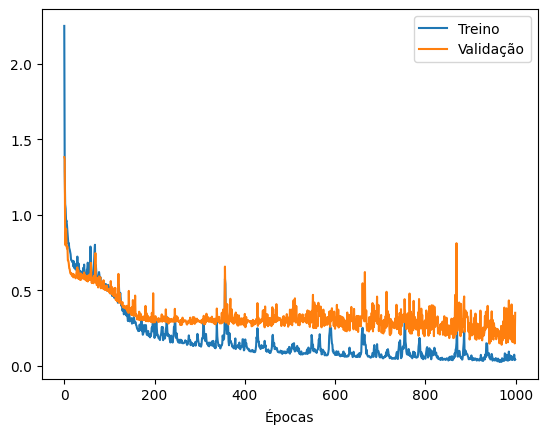

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

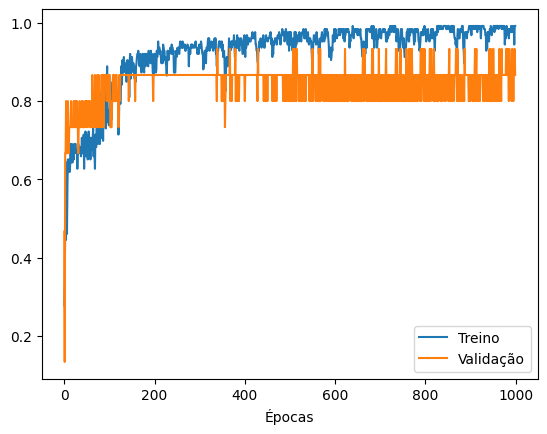

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

net.train(False)
for data in data_test:
    x_test, y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    c_matrix = confusion_matrix(y_test, y_pred, labels=range(3))

c_matrix

array([[ 9,  0,  0],
       [ 0, 12,  0],
       [ 0,  0, 15]])

In [19]:
from sklearn.metrics import classification_report

net.train(False)

for data in data_test:
    x_test,y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)

    print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        15

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

